<a href="https://colab.research.google.com/github/sachinibuddhika/Big-Data-Project-Analysis-on-Swiggy-Zomato-Order-Information-Dataseton/blob/main/BigData_195006X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount google drive**

In [396]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Initialize spark context**

In [397]:
#install pyspark
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [398]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("OrderAnalysis") \
    .getOrCreate()

In [399]:
spark

In [400]:
conf = spark.sparkContext.getConf()

# Print the configuration settings
print("spark.app.name = ", conf.get("spark.app.name"))
print("spark.master = ", conf.get("spark.master"))
print("spark.executor.memory = ", conf.get("spark.executor.memory"))

spark.app.name =  OrderAnalysis
spark.master =  local[*]
spark.executor.memory =  None


In [401]:
# Load the CSV file into a DataFrame
df = spark.read.csv('/content/drive/My Drive/BigData/DataSet/Rider-Info.csv', header=True)


**Read the dataset**

In [402]:
#specifying the dataset to read
help(spark.read.csv)

Help on method csv in module pyspark.sql.readwriter:

csv(path: Union[str, List[str]], schema: Union[pyspark.sql.types.StructType, str, NoneType] = None, sep: Optional[str] = None, encoding: Optional[str] = None, quote: Optional[str] = None, escape: Optional[str] = None, comment: Optional[str] = None, header: Union[bool, str, NoneType] = None, inferSchema: Union[bool, str, NoneType] = None, ignoreLeadingWhiteSpace: Union[bool, str, NoneType] = None, ignoreTrailingWhiteSpace: Union[bool, str, NoneType] = None, nullValue: Optional[str] = None, nanValue: Optional[str] = None, positiveInf: Optional[str] = None, negativeInf: Optional[str] = None, dateFormat: Optional[str] = None, timestampFormat: Optional[str] = None, maxColumns: Union[str, int, NoneType] = None, maxCharsPerColumn: Union[str, int, NoneType] = None, maxMalformedLogPerPartition: Union[str, int, NoneType] = None, mode: Optional[str] = None, columnNameOfCorruptRecord: Optional[str] = None, multiLine: Union[bool, str, NoneType] 

In [403]:
# Load the CSV file into a DataFrame
df = spark.read.csv('/content/drive/My Drive/BigData/DataSet/Rider-Info.csv', header=True)

In [404]:
df.show(5)

+-------------------+--------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+--------------+----------------+---------+------------------+--------------------+-------------------+-------------------+----------------+------------------+--------------+
|         order_time|order_id|         order_date|         allot_time|        accept_time|        pickup_time|     delivered_time|rider_id|first_mile_distance|last_mile_distance|alloted_orders|delivered_orders|cancelled|undelivered_orders|lifetime_order_count|reassignment_method|reassignment_reason|reassigned_order|      session_time|cancelled_time|
+-------------------+--------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+--------------+----------------+---------+------------------+--------------------+-------------------+----------------

In [405]:
df.columns


['order_time',
 'order_id',
 'order_date',
 'allot_time',
 'accept_time',
 'pickup_time',
 'delivered_time',
 'rider_id',
 'first_mile_distance',
 'last_mile_distance',
 'alloted_orders',
 'delivered_orders',
 'cancelled',
 'undelivered_orders',
 'lifetime_order_count',
 'reassignment_method',
 'reassignment_reason',
 'reassigned_order',
 'session_time',
 'cancelled_time']

**Preprocess data**

In [406]:
from pyspark.sql import functions as F

Dropping columns

In [407]:
columns_to_drop = ['accept_time', 'undelivered_orders','reassignment_method', 'reassignment_reason']
df2 = df.drop(*columns_to_drop)

df2.show(5)

+-------------------+--------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------------+--------------+
|         order_time|order_id|         order_date|         allot_time|        pickup_time|     delivered_time|rider_id|first_mile_distance|last_mile_distance|alloted_orders|delivered_orders|cancelled|lifetime_order_count|reassigned_order|      session_time|cancelled_time|
+-------------------+--------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------------+--------------+
|2021-01-26 02:21:35|  556753|2021-01-26 00:00:00|2021-01-26 02:21:59|2021-01-26 02:32:51|2021-01-26 02:49:47|   11696|             1.5666|              2.65|          46.0|        

In [408]:
df2.columns

['order_time',
 'order_id',
 'order_date',
 'allot_time',
 'pickup_time',
 'delivered_time',
 'rider_id',
 'first_mile_distance',
 'last_mile_distance',
 'alloted_orders',
 'delivered_orders',
 'cancelled',
 'lifetime_order_count',
 'reassigned_order',
 'session_time',
 'cancelled_time']

Dropping null rows

In [409]:
# display null values
df2.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df2.columns]).show()

+----------+--------+----------+----------+-----------+--------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------+--------------+
|order_time|order_id|order_date|allot_time|pickup_time|delivered_time|rider_id|first_mile_distance|last_mile_distance|alloted_orders|delivered_orders|cancelled|lifetime_order_count|reassigned_order|session_time|cancelled_time|
+----------+--------+----------+----------+-----------+--------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------+--------------+
|         0|       0|         0|         0|       2421|          5218|       0|                  0|                 0|         16948|           17341|        0|                  53|          436247|        3675|        444782|
+----------+--------+----------+----------+-----------+--------------+--------+-------------

In [410]:
df2 = df2.filter(df.accept_time.isNotNull())

In [411]:
rows_to_drop = ['pickup_time','delivered_time']

In [412]:
for row in rows_to_drop:
  df2 = df2.filter(df[row].isNotNull())

In [413]:
# display null values
df2.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df2.columns]).show()

+----------+--------+----------+----------+-----------+--------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------+--------------+
|order_time|order_id|order_date|allot_time|pickup_time|delivered_time|rider_id|first_mile_distance|last_mile_distance|alloted_orders|delivered_orders|cancelled|lifetime_order_count|reassigned_order|session_time|cancelled_time|
+----------+--------+----------+----------+-----------+--------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------+--------------+
|         0|       0|         0|         0|          0|             0|       0|                  0|                 0|         16299|           16486|        0|                   2|          431751|        3531|        444782|
+----------+--------+----------+----------+-----------+--------------+--------+-------------

In [414]:
df2.count()

444782

Filling missing values

In [415]:
from pyspark.sql.functions import mean

In [416]:
# Fill missing values with mean in specified columns
columns_to_fill = ['alloted_orders', 'delivered_orders', 'lifetime_order_count', 'session_time']
mean_values = df2.select([mean(col).alias(col) for col in columns_to_fill]).collect()[0].asDict()
df2 = df2.fillna(mean_values)

In [417]:
# display null values
df2.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df2.columns]).show()

+----------+--------+----------+----------+-----------+--------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------+--------------+
|order_time|order_id|order_date|allot_time|pickup_time|delivered_time|rider_id|first_mile_distance|last_mile_distance|alloted_orders|delivered_orders|cancelled|lifetime_order_count|reassigned_order|session_time|cancelled_time|
+----------+--------+----------+----------+-----------+--------------+--------+-------------------+------------------+--------------+----------------+---------+--------------------+----------------+------------+--------------+
|         0|       0|         0|         0|          0|             0|       0|                  0|                 0|             0|               0|        0|                   0|          431751|           0|        444782|
+----------+--------+----------+----------+-----------+--------------+--------+-------------

**Feature Engineering**

Add Column Order Processing Time

In [418]:
from pyspark.sql.functions import col, unix_timestamp, when, floor

In [419]:
from pyspark.sql.functions import col, unix_timestamp, when

# Calculate order processing time in minutes
df2 = df2.withColumn("order_processing_time_minutes",
                     (when(col("delivered_time").isNotNull(),
                           (unix_timestamp("delivered_time", "yyyy-MM-dd HH:mm:ss") - unix_timestamp("order_time", "yyyy-MM-dd HH:mm:ss")) / 60)
                      .otherwise((unix_timestamp("cancelled_time", "yyyy-MM-dd HH:mm:ss") - unix_timestamp("order_time", "yyyy-MM-dd HH:mm:ss")) / 60)
                     ).cast("int"))

# Select and display only the order processing time in minutes
df2.show(truncate=False)


+-------------------+--------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+-----------------+------------------+---------+--------------------+----------------+------------------+--------------+-----------------------------+
|order_time         |order_id|order_date         |allot_time         |pickup_time        |delivered_time     |rider_id|first_mile_distance|last_mile_distance|alloted_orders   |delivered_orders  |cancelled|lifetime_order_count|reassigned_order|session_time      |cancelled_time|order_processing_time_minutes|
+-------------------+--------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+-----------------+------------------+---------+--------------------+----------------+------------------+--------------+-----------------------------+
|2021-01-26 02:21:35|556753  |2021-01-26 00:00:00|2021-01-26 02:21:59|2021-0

Add Columns Average Order Volume,Total Distrance Per Order

In [420]:
# Calculate average order volume per rider
df2 = df2.withColumn("average_order_volume", col("delivered_orders") / col("alloted_orders"))

# Compute total distance traveled per order
df2 = df2.withColumn("total_distance_per_order", col("first_mile_distance") + col("last_mile_distance"))




# Show the updated DataFrame
df2.show()


+-------------------+--------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+-----------------+------------------+---------+--------------------+----------------+------------------+--------------+-----------------------------+--------------------+------------------------+
|         order_time|order_id|         order_date|         allot_time|        pickup_time|     delivered_time|rider_id|first_mile_distance|last_mile_distance|   alloted_orders|  delivered_orders|cancelled|lifetime_order_count|reassigned_order|      session_time|cancelled_time|order_processing_time_minutes|average_order_volume|total_distance_per_order|
+-------------------+--------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+------------------+-----------------+------------------+---------+--------------------+----------------+------------------+--------------+---------------

**Analysis**

Order Processing Time Distribution

In [421]:
#import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
import numpy as np

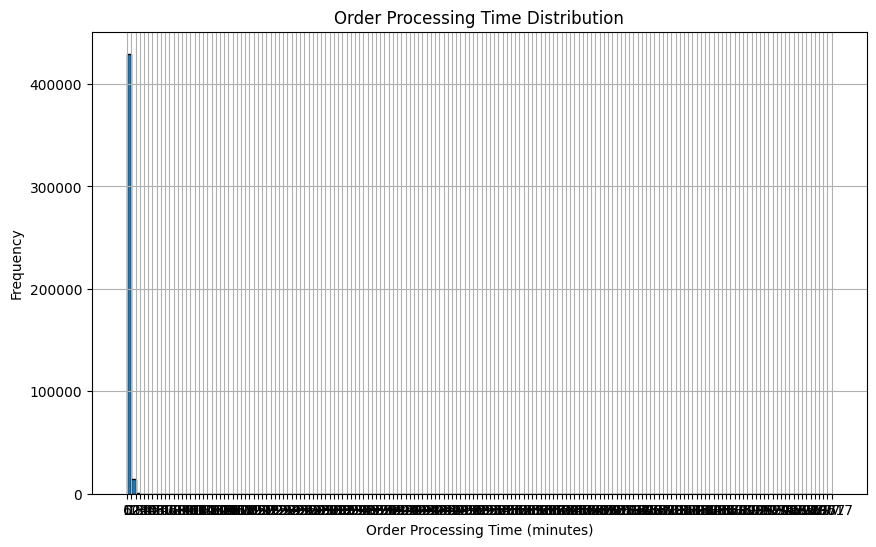

In [422]:

# Extract order processing times from the DataFrame
order_processing_times = df2.select("order_processing_time_minutes").rdd.flatMap(lambda x: x).collect()

# Determine bin edges based on order processing times
max_time = max(order_processing_times)
num_bins = int(max_time / 60) + 1
bin_edges = np.linspace(0, max_time, num_bins + 1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(order_processing_times, bins=bin_edges, edgecolor='black')
plt.title("Order Processing Time Distribution")
plt.xlabel("Order Processing Time (minutes)")
plt.ylabel("Frequency")
plt.xticks(bin_edges)  # Set x-axis ticks to match bin boundaries
plt.grid(True)
plt.show()





In [423]:
df2.printSchema()


root
 |-- order_time: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- allot_time: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- delivered_time: string (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- first_mile_distance: string (nullable = true)
 |-- last_mile_distance: string (nullable = true)
 |-- alloted_orders: string (nullable = false)
 |-- delivered_orders: string (nullable = false)
 |-- cancelled: string (nullable = true)
 |-- lifetime_order_count: string (nullable = false)
 |-- reassigned_order: string (nullable = true)
 |-- session_time: string (nullable = false)
 |-- cancelled_time: string (nullable = true)
 |-- order_processing_time_minutes: integer (nullable = true)
 |-- average_order_volume: double (nullable = true)
 |-- total_distance_per_order: double (nullable = true)



Analysis of Correlation Between Total Distance and Order Processing Time

In [429]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

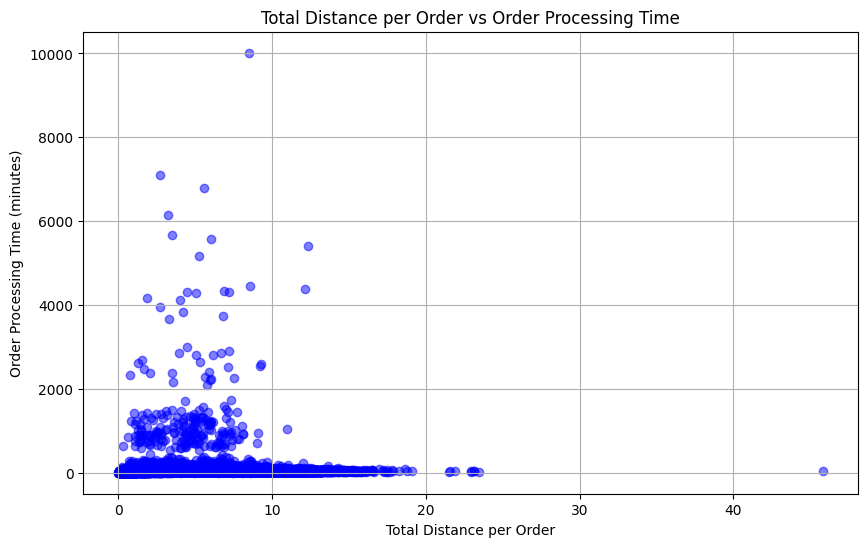

In [431]:
# Scatter plot between total_distance_per_order and order_processing_time_minutes
plt.figure(figsize=(10, 6))
plt.scatter(df2.select('total_distance_per_order').collect(),
            df2.select('order_processing_time_minutes').collect(),
            color='blue', alpha=0.5)
plt.title('Total Distance per Order vs Order Processing Time')
plt.xlabel('Total Distance per Order')
plt.ylabel('Order Processing Time (minutes)')
plt.grid(True)
plt.show()


Analysis of Correlation Between Time of the Day and Order Processing Time

In [443]:
from pyspark.sql.functions import col, year, month
import matplotlib.pyplot as plt

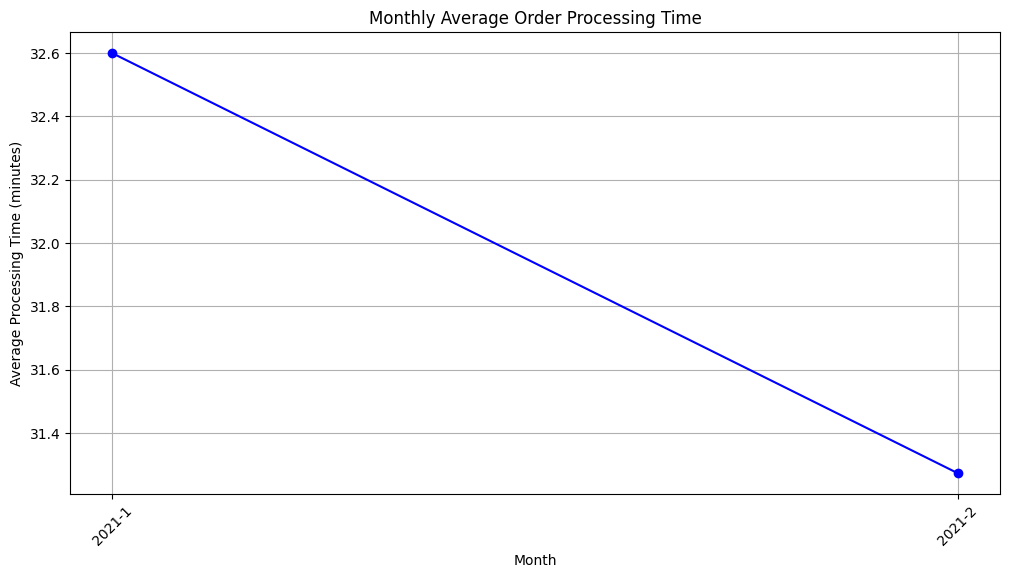

In [444]:


# Extract year and month from the order_date column
df2 = df2.withColumn("year", year("order_date"))
df2 = df2.withColumn("month", month("order_date"))

# Calculate average processing time on a monthly basis
monthly_avg_processing_time = df2.groupBy("year", "month").avg("order_processing_time_minutes").orderBy("year", "month").toPandas()

# Combine year and month into a single column for plotting
monthly_avg_processing_time["year_month"] = monthly_avg_processing_time["year"].astype(str) + "-" + monthly_avg_processing_time["month"].astype(str)

# Plotting the monthly trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_processing_time["year_month"], monthly_avg_processing_time["avg(order_processing_time_minutes)"], marker='o', color='b', linestyle='-')
plt.title("Monthly Average Order Processing Time")
plt.xlabel("Month")
plt.ylabel("Average Processing Time (minutes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

